In [18]:
import sys
import os
import pandas as pd
# If running in an environment where __file__ is not defined, manually set the path
project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(project_dir, 'src'))

from clean import handle_missing_values, convert_to_datetime, calculate_trip_duration, calculate_iqr_bounds, remove_outliers, drop_columns_with_missing_values, detect_outliers
from add_holiday import add_holiday_feature
from fetch_weather import fetch_weather_data
from extract_feature import normalize_features, calculate_distance

In [32]:

# Load datasets
completed_orders = pd.read_csv('../data/nb.csv')
delivery_requests = pd.read_csv('../data/driver_locations_during_request.csv')


In [33]:
# delivery_requests.columns
completed_orders.columns

Index(['Trip ID', 'Trip Origin', 'Trip Destination', 'Trip Start Time',
       'Trip End Time'],
      dtype='object')

In [34]:
print(len(completed_orders))

536020


In [35]:
# Rename the column to have a common key for merging
completed_orders.rename(columns={'Trip ID': 'order_id'}, inplace=True)

# Find IDs in completed_orders that are not in delivery_requests
ids_in_completed_not_in_delivery = set(completed_orders['order_id']) - set(delivery_requests['order_id'])
# print("IDs in completed_orders but not in delivery_requests:")
# print(ids_in_completed_not_in_delivery)


In [36]:
print(len(ids_in_completed_not_in_delivery))

509528


### Note: This number (509528) are rejected ride or car

In [37]:

# Find IDs in delivery_requests that are not in completed_orders
ids_in_delivery_not_in_completed = set(delivery_requests['order_id']) - set(completed_orders['order_id'])
print(len(ids_in_delivery_not_in_completed))

0


In [38]:
print(completed_orders.head())

   order_id                         Trip Origin  \
0    391996  6.508813001668548,3.37740316890347   
1    391997                 6.4316714,3.4555375   
2    391998         6.631679399999999,3.3388976   
3    391999         6.572757200000001,3.3677082   
4    392001                 6.6010417,3.2766339   

                  Trip Destination      Trip Start Time        Trip End Time  
0      6.650969799999999,3.3450307  2021-07-01 07:28:04  2021-07-01 07:29:37  
1  6.4280814653326,3.4721885847586  2021-07-01 06:38:04  2021-07-01 07:07:28  
2      6.508324099999999,3.3590397  2021-07-01 06:21:02  2021-07-01 07:02:23  
3      6.584881099999999,3.3614073  2021-07-01 07:16:07  2021-07-01 07:29:42  
4              6.4501069,3.3916154  2021-07-01 09:30:59  2021-07-01 09:34:36  


In [39]:

# Handle missing values
completed_orders = handle_missing_values(completed_orders, ['Trip Start Time', 'Trip End Time'])


In [40]:
#check missing values for order
print(completed_orders.isnull().sum())

order_id            0
Trip Origin         0
Trip Destination    0
Trip Start Time     0
Trip End Time       0
dtype: int64


In [41]:

# Convert to datetime
completed_orders = convert_to_datetime(completed_orders, ['Trip Start Time', 'Trip End Time'])

# Calculate trip duration
completed_orders = calculate_trip_duration(completed_orders, 'Trip Start Time', 'Trip End Time')

# Calculate IQR bounds
lower_bound, upper_bound = calculate_iqr_bounds(completed_orders, 'trip_duration')
# Detect outliers
outliers_iqr = detect_outliers(completed_orders, 'trip_duration', lower_bound, upper_bound)

# Remove outliers
completed_orders_no_outliers = remove_outliers(completed_orders, 'trip_duration', lower_bound, upper_bound)


In [42]:

# Drop columns with completely missing values in delivery_requests
delivery_requests = drop_columns_with_missing_values(delivery_requests, ['created_at', 'updated_at'])

In [ ]:
# check few rows of delivery request
delivery_requests.head()
# print(delivery_requests.info())


,id,order_id,driver_id,driver_action,lat,lng
0,1,392001,243828,accepted,6.602207,3.270465
1,2,392001,243588,rejected,6.592097,3.287445
2,3,392001,243830,rejected,6.596133,3.281784
3,4,392001,243539,rejected,6.596142,3.280526
4,5,392001,171653,rejected,6.609232,3.288800


In [101]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

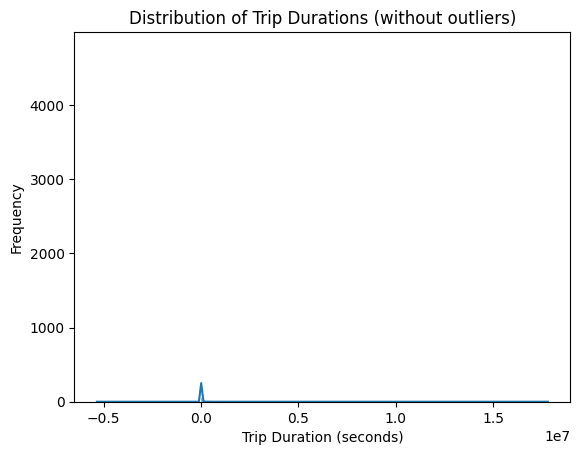

In [12]:
# Visualize the distribution of trip durations without outliers
sns.histplot(outliers_iqr['trip_duration'], kde=True)
plt.title('Distribution of Trip Durations (without outliers)')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

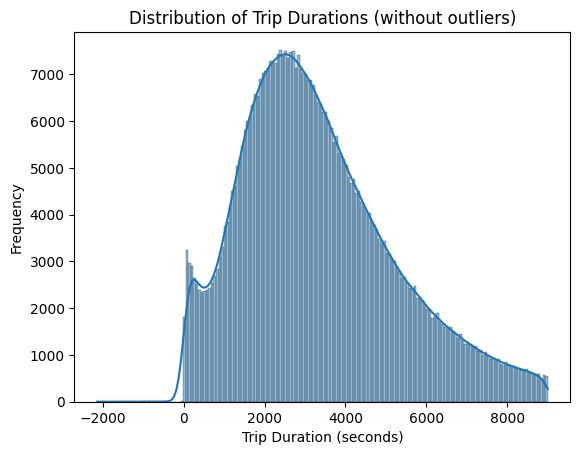

In [13]:
# Visualize the distribution of trip durations without outliers
sns.histplot(completed_orders_no_outliers['trip_duration'], kde=True)
plt.title('Distribution of Trip Durations (without outliers)')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')
plt.show()


In [14]:
# check missing values for delivery
print(delivery_requests.isnull().sum())


id               0
order_id         0
driver_id        0
driver_action    0
lat              0
lng              0
dtype: int64


In [44]:
# Add holiday feature
completed_orders = add_holiday_feature(completed_orders)

Completed adding holiday feature.


In [45]:
print(completed_orders['is_holiday'].unique())


[False  True]


In [46]:
print(len(ids_in_completed_not_in_delivery))

509528


In [48]:
# Merge datasets on order_id (assuming 'order_id' in delivery_requests and 'Trip ID' in completed_orders)
completed_orders.rename(columns={'Trip ID': 'order_id'}, inplace=True)
cleaned_merged = pd.merge(delivery_requests, completed_orders, on='order_id')

In [50]:
print(cleaned_merged['is_holiday'].unique())


[False]


### Note: most driver rejected due to holiday, that is why i returned only false. So 509528 data is removed when we are merged, let check if we have enough rejected data so that we don't have worry 509528

In [51]:
# This data is not affected by holiday anmore so we don't add to holiday feature
# Count the number of rows where 'driver_action' is 'accepted'
rejected = (cleaned_merged['driver_action'] == 'rejected').sum()
print(rejected)

1531837


In [52]:
cleaned_merged = cleaned_merged.drop(columns = 'is_holiday')

In [53]:
print(len(cleaned_merged))

1557740


In [54]:
# Extract latitude and longitude from Trip Origin and Trip Destination
cleaned_merged[['Trip Origin Lat', 'Trip Origin Lng']] = cleaned_merged['Trip Origin'].str.split(',', expand=True).astype(float)
cleaned_merged[['Trip Destination Lat', 'Trip Destination Lng']] = cleaned_merged['Trip Destination'].str.split(',', expand=True).astype(float)


In [55]:
cleaned_merged.columns

Index(['id', 'order_id', 'driver_id', 'driver_action', 'lat', 'lng',
       'Trip Origin', 'Trip Destination', 'Trip Start Time', 'Trip End Time',
       'trip_duration', 'Trip Origin Lat', 'Trip Origin Lng',
       'Trip Destination Lat', 'Trip Destination Lng'],
      dtype='object')

In [20]:

# Fetch weather data
cleaned_merged = fetch_weather_data(cleaned_merged)

Processed 1/1557740 rows. Weather condition: rain
Processed 2/1557740 rows. Weather condition: rain
Processed 3/1557740 rows. Weather condition: rain
Processed 4/1557740 rows. Weather condition: rain
Processed 5/1557740 rows. Weather condition: rain
Processed 6/1557740 rows. Weather condition: rain
Processed 7/1557740 rows. Weather condition: rain
Processed 8/1557740 rows. Weather condition: rain
Processed 9/1557740 rows. Weather condition: rain
Processed 10/1557740 rows. Weather condition: rain
Processed 11/1557740 rows. Weather condition: rain
Processed 12/1557740 rows. Weather condition: rain
Processed 13/1557740 rows. Weather condition: rain
Processed 14/1557740 rows. Weather condition: rain
Processed 15/1557740 rows. Weather condition: rain
Processed 16/1557740 rows. Weather condition: rain
Processed 17/1557740 rows. Weather condition: rain
Processed 18/1557740 rows. Weather condition: rain
Processed 19/1557740 rows. Weather condition: rain
Processed 20/1557740 rows. Weather condi

Progress saved at row 50
Processed 50/1557740 rows. Weather condition: rain
Processed 51/1557740 rows. Weather condition: rain
Processed 52/1557740 rows. Weather condition: rain
Processed 53/1557740 rows. Weather condition: rain
Processed 54/1557740 rows. Weather condition: rain
Processed 55/1557740 rows. Weather condition: rain
Processed 56/1557740 rows. Weather condition: rain
Processed 57/1557740 rows. Weather condition: rain
Processed 58/1557740 rows. Weather condition: rain
Processed 59/1557740 rows. Weather condition: rain
Processed 60/1557740 rows. Weather condition: rain
Processed 61/1557740 rows. Weather condition: rain
Processed 62/1557740 rows. Weather condition: rain
Processed 63/1557740 rows. Weather condition: rain
Processed 64/1557740 rows. Weather condition: rain
Processed 65/1557740 rows. Weather condition: rain
Processed 66/1557740 rows. Weather condition: rain
Processed 67/1557740 rows. Weather condition: rain
Processed 68/1557740 rows. Weather condition: rain
Proces

KeyboardInterrupt: 

In [56]:
# fetching weather data takes time. in our case it is enough 401700 data for next stepde
delivery_completed = pd.read_csv('weather_data_progress.csv')

/tmp/ipykernel_275951/1114501718.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  delivery_completed = pd.read_csv('weather_data_progress.csv')


In [61]:
# Check the contents and data type of column 16 (index 15)
column_16_data = delivery_completed.iloc[:, 16]
column_16_data

0          rain
1          rain
2          rain
3          rain
4          rain
           ... 
1017850     NaN
1017851     NaN
1017852     NaN
1017853     NaN
1017854     NaN
Name: weather, Length: 1017855, dtype: object

In [62]:
# Get unique data types in column 16
unique_types = column_16_data.apply(type).unique()

# Display the unique types
print(unique_types)

[<class 'str'> <class 'float'>]


In [63]:
# Filter the DataFrame to exclude rows with values greater than 41700
# Select only the first 41,700 rows
df = delivery_completed.iloc[:41700]

In [64]:
df.to_csv('../data/delivery_completed.csv', index = False)

In [66]:
delivery_completed = pd.read_csv('../data/delivery_completed.csv')
print(delivery_completed.head())

   id  order_id  driver_id driver_action       lat       lng  \
0   1    392001     243828      accepted  6.602207  3.270465   
1   2    392001     243588      rejected  6.592097  3.287445   
2   3    392001     243830      rejected  6.596133  3.281784   
3   4    392001     243539      rejected  6.596142  3.280526   
4   5    392001     171653      rejected  6.609232  3.288800   

           Trip Origin     Trip Destination      Trip Start Time  \
0  6.6010417,3.2766339  6.4501069,3.3916154  2021-07-01 09:30:59   
1  6.6010417,3.2766339  6.4501069,3.3916154  2021-07-01 09:30:59   
2  6.6010417,3.2766339  6.4501069,3.3916154  2021-07-01 09:30:59   
3  6.6010417,3.2766339  6.4501069,3.3916154  2021-07-01 09:30:59   
4  6.6010417,3.2766339  6.4501069,3.3916154  2021-07-01 09:30:59   

         Trip End Time  trip_duration  is_holiday  Trip Origin Lat  \
0  2021-07-01 09:34:36          217.0       False         6.601042   
1  2021-07-01 09:34:36          217.0       False         6.601042

In [69]:
# drop holiday column.
delivery_completed = delivery_completed.drop(columns = 'is_holiday')

In [70]:
print(len(delivery_completed))

41700


In [73]:
# Convert to datetime
delivery_completed = convert_to_datetime(delivery_completed, ['Trip Start Time', 'Trip End Time'])


In [74]:
# Add additional features
delivery_completed['hour'] = delivery_completed['Trip Start Time'].dt.hour
delivery_completed['day_of_week'] = delivery_completed['Trip Start Time'].dt.dayofweek
delivery_completed['is_weekend'] = delivery_completed['day_of_week'] >= 5

In [75]:
print(delivery_completed.columns)

Index(['id', 'order_id', 'driver_id', 'driver_action', 'lat', 'lng',
       'Trip Origin', 'Trip Destination', 'Trip Start Time', 'Trip End Time',
       'trip_duration', 'Trip Origin Lat', 'Trip Origin Lng',
       'Trip Destination Lat', 'Trip Destination Lng', 'weather', 'hour',
       'day_of_week', 'is_weekend'],
      dtype='object')


# Next Step...

In [76]:
from extract_feature import calculate_distance, clean_features, count_orders_within_radius,compute_clusters

In [77]:
# Create an empty list to store distances
distances = []

# Iterate over rows with index
for index, row in delivery_completed.iterrows():
    distance = calculate_distance(row)
    distances.append(distance)
    
    # Print progress for every 10th row
    if (index + 1) % 10 == 0:
        print(f"Row {index + 1}: Distance calculated.")

Row 10: Distance calculated.
Row 20: Distance calculated.
Row 30: Distance calculated.
Row 40: Distance calculated.
Row 50: Distance calculated.
Row 60: Distance calculated.
Row 70: Distance calculated.
Row 80: Distance calculated.
Row 90: Distance calculated.
Row 100: Distance calculated.
Row 110: Distance calculated.
Row 120: Distance calculated.
Row 130: Distance calculated.
Row 140: Distance calculated.
Row 150: Distance calculated.
Row 160: Distance calculated.
Row 170: Distance calculated.
Row 180: Distance calculated.
Row 190: Distance calculated.
Row 200: Distance calculated.
Row 210: Distance calculated.
Row 220: Distance calculated.
Row 230: Distance calculated.
Row 240: Distance calculated.
Row 250: Distance calculated.
Row 260: Distance calculated.
Row 270: Distance calculated.
Row 280: Distance calculated.
Row 290: Distance calculated.
Row 300: Distance calculated.
Row 310: Distance calculated.
Row 320: Distance calculated.
Row 330: Distance calculated.
Row 340: Distance c

In [79]:
# Add the distances as a new column to the dataframe
delivery_completed['Distance_km'] = distances

In [81]:

# Convert Trip Duration from seconds to hours
delivery_completed['Trip Duration Hours'] = delivery_completed['trip_duration'] / 3600

# Calculate average speed (distance / duration)
delivery_completed['Average Speed (km/h)'] = delivery_completed['Distance_km'] / delivery_completed['Trip Duration Hours']

# Display rows with unrealistic speeds (e.g., speeds greater than 150 km/h)
unrealistic_speeds = delivery_completed[delivery_completed['Average Speed (km/h)'] > 150]
print("Trips with unrealistic speeds:")
print(unrealistic_speeds)


Trips with unrealistic speeds:
          id  order_id  driver_id driver_action       lat       lng  \
0          1    392001     243828      accepted  6.602207  3.270465   
1          2    392001     243588      rejected  6.592097  3.287445   
2          3    392001     243830      rejected  6.596133  3.281784   
3          4    392001     243539      rejected  6.596142  3.280526   
4          5    392001     171653      rejected  6.609232  3.288800   
...      ...       ...        ...           ...       ...       ...   
41277  41278    394059     243116      rejected  6.430738  3.437666   
41278  41279    394059     244057      rejected  6.435868  3.443895   
41279  41280    394059     243490      rejected  6.429831  3.452760   
41280  41281    394059     243184      rejected  6.433992  3.424971   
41281  41282    394059     241353      rejected  6.434687  3.452495   

                       Trip Origin                     Trip Destination  \
0              6.6010417,3.2766339       

In [82]:
print(len(unrealistic_speeds))

689


In [84]:

# Filter out rows with unrealistic speeds
filtered_requests = delivery_completed[delivery_completed['Average Speed (km/h)'] <= 150]

# Find the maximum distance from the filtered rows
max_distance = filtered_requests['Distance_km'].max()

In [85]:
max_distance

56.34371763330095

In [86]:
print(len(filtered_requests))

41011


In [87]:
print(filtered_requests.head())

    id  order_id  driver_id driver_action       lat       lng  \
10  11    392005     245597      accepted  6.549147  3.392184   
11  12    392005     243172      rejected  6.570408  3.396597   
12  13    392005     243392      rejected  6.566144  3.366483   
13  14    392005     243281      rejected  6.576791  3.389592   
14  15    392005     244078      rejected  6.577215  3.371172   

                    Trip Origin             Trip Destination  \
10  6.565087699999999,3.3844415  6.499696300000001,3.3509075   
11  6.565087699999999,3.3844415  6.499696300000001,3.3509075   
12  6.565087699999999,3.3844415  6.499696300000001,3.3509075   
13  6.565087699999999,3.3844415  6.499696300000001,3.3509075   
14  6.565087699999999,3.3844415  6.499696300000001,3.3509075   

       Trip Start Time       Trip End Time  ...  Trip Origin Lng  \
10 2021-07-01 10:53:36 2021-07-01 11:27:51  ...         3.384441   
11 2021-07-01 10:53:36 2021-07-01 11:27:51  ...         3.384441   
12 2021-07-01 10:53:

In [88]:
filtered_requests.columns

Index(['id', 'order_id', 'driver_id', 'driver_action', 'lat', 'lng',
       'Trip Origin', 'Trip Destination', 'Trip Start Time', 'Trip End Time',
       'trip_duration', 'Trip Origin Lat', 'Trip Origin Lng',
       'Trip Destination Lat', 'Trip Destination Lng', 'weather', 'hour',
       'day_of_week', 'is_weekend', 'Distance_km', 'Trip Duration Hours',
       'Average Speed (km/h)'],
      dtype='object')

In [89]:
# Normalize selected features
features_to_normalize = ['trip_duration', 'Distance_km', 'Average Speed (km/h)']
print("Columns before normalization:", filtered_requests.columns)
filtered_requests = normalize_features(filtered_requests, features_to_normalize)

Columns before normalization: Index(['id', 'order_id', 'driver_id', 'driver_action', 'lat', 'lng',
       'Trip Origin', 'Trip Destination', 'Trip Start Time', 'Trip End Time',
       'trip_duration', 'Trip Origin Lat', 'Trip Origin Lng',
       'Trip Destination Lat', 'Trip Destination Lng', 'weather', 'hour',
       'day_of_week', 'is_weekend', 'Distance_km', 'Trip Duration Hours',
       'Average Speed (km/h)'],
      dtype='object')


/home/air/gokada_delivery_optimization/src/extract_feature.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns] = scaler.fit_transform(df[columns])


In [90]:
# Define the function to count orders within a given radius
def count_orders_within_radius(df, radius=0.5):
    """
    Count the number of accepted and unfulfilled orders within a given radius (in km).
    """
    # Initialize columns to count orders within the radius
    df['accepted_within_radius'] = 0
    df['unfulfilled_within_radius'] = 0
    
    for index, row in df.iterrows():
        if row['Distance_km'] <= radius:
            if row['driver_action'] == 'accepted':
                df.loc[index, 'accepted_within_radius'] = 1
            elif row['driver_action'] == 'rejected':
                df.loc[index, 'unfulfilled_within_radius'] = 1
    
    # Summarize the counts
    total_accepted = df['accepted_within_radius'].sum()
    total_unfulfilled = df['unfulfilled_within_radius'].sum()
    
    return total_accepted, total_unfulfilled


In [91]:
# use .copy() while creating the new dataframe will solve the warning:
filtered_requests = filtered_requests.copy()

In [92]:
print(len(filtered_requests))

41011


In [93]:

# Apply the function to count orders within the specified radius
total_accepted, total_unfulfilled = count_orders_within_radius(filtered_requests, radius=0.5)


In [94]:

print(f"Total accepted orders within 0.5 km: {total_accepted}")
print(f"Total unfulfilled orders within 0.5 km: {total_unfulfilled}")

Total accepted orders within 0.5 km: 1074
Total unfulfilled orders within 0.5 km: 39544


In [96]:
filtered_requests.columns

Index(['id', 'order_id', 'driver_id', 'driver_action', 'lat', 'lng',
       'Trip Origin', 'Trip Destination', 'Trip Start Time', 'Trip End Time',
       'trip_duration', 'Trip Origin Lat', 'Trip Origin Lng',
       'Trip Destination Lat', 'Trip Destination Lng', 'weather', 'hour',
       'day_of_week', 'is_weekend', 'Distance_km', 'Trip Duration Hours',
       'Average Speed (km/h)', 'accepted_within_radius',
       'unfulfilled_within_radius'],
      dtype='object')

In [97]:
# Compute clusters for origins and destinations
filtered_requests, kmeans_origin, kmeans_destination = compute_clusters(filtered_requests, n_clusters=10)


In [99]:
def plot_clusters(df, kmeans, lat_col, lng_col, cluster_col, title):
    """
    Plot clusters on a scatter plot.
    """
    plt.figure(figsize=(12, 8))
    plt.scatter(df[lat_col], df[lng_col], c=df[cluster_col], cmap='viridis', marker='o', alpha=0.6, s=100)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x')
    plt.title(title)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.grid(True)
    plt.show()


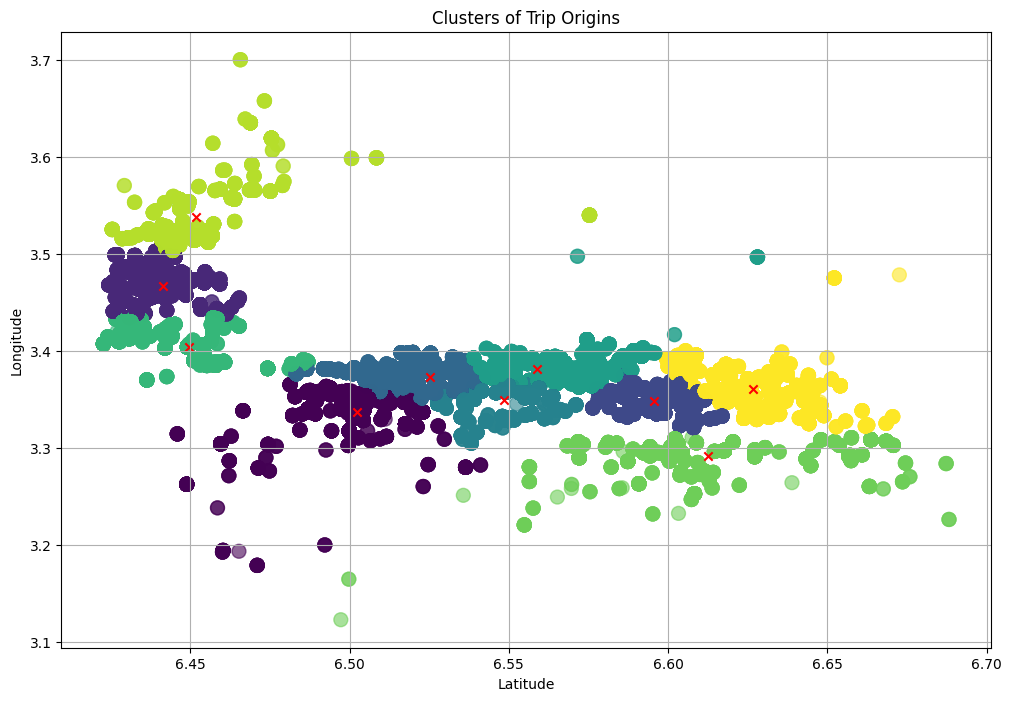

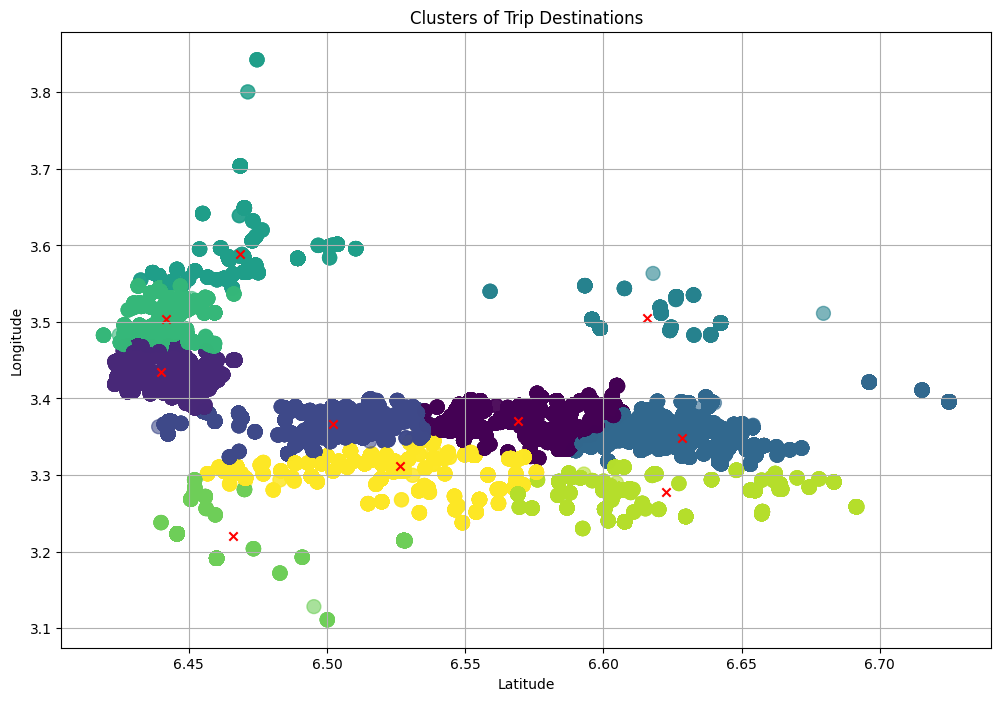

In [102]:

# Plot clusters for trip origins
plot_clusters(filtered_requests, kmeans_origin, 'Trip Origin Lat', 'Trip Origin Lng', 'origin_cluster', 'Clusters of Trip Origins')

# Plot clusters for trip destinations
plot_clusters(filtered_requests, kmeans_destination, 'Trip Destination Lat', 'Trip Destination Lng', 'destination_cluster', 'Clusters of Trip Destinations')


In [103]:
filtered_requests.columns

Index(['id', 'order_id', 'driver_id', 'driver_action', 'lat', 'lng',
       'Trip Origin', 'Trip Destination', 'Trip Start Time', 'Trip End Time',
       'trip_duration', 'Trip Origin Lat', 'Trip Origin Lng',
       'Trip Destination Lat', 'Trip Destination Lng', 'weather', 'hour',
       'day_of_week', 'is_weekend', 'Distance_km', 'Trip Duration Hours',
       'Average Speed (km/h)', 'accepted_within_radius',
       'unfulfilled_within_radius', 'origin_cluster', 'destination_cluster'],
      dtype='object')

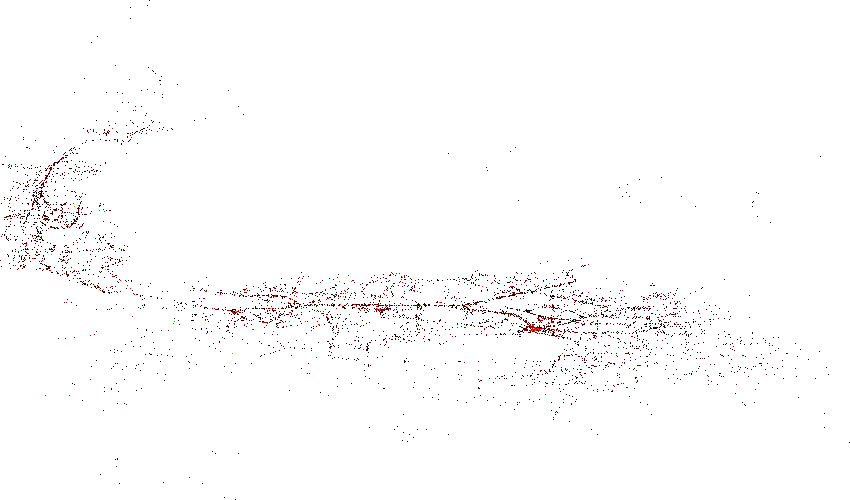

In [104]:
import datashader as ds, pandas as pd, colorcet
# df  = pd.read_csv('census.csv')
cvs = ds.Canvas(plot_width=850, plot_height=500)
agg = cvs.points(filtered_requests, 'lat', 'lng')
img = ds.tf.shade(agg, cmap=colorcet.fire, how='log')
img

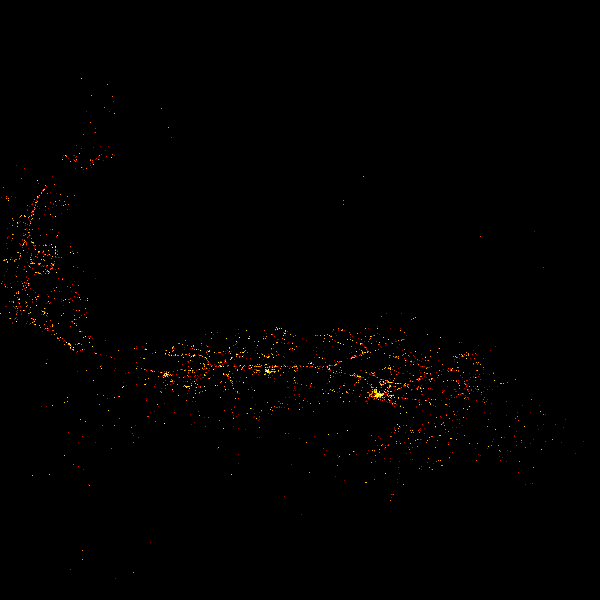

In [105]:
import datashader as ds, pandas as pd, colorcet as cc
agg = ds.Canvas().points(filtered_requests, 'lat', 'lng')
ds.tf.set_background(ds.tf.shade(agg, cmap=cc.fire), "black")

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
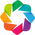

BokehModel(combine_events=True, render_bundle={'docs_json': {'ca73cc83-51a8-4579-b63d-422a19731392': {'version…

In [108]:
import holoviews as hv
from holoviews.element.tiles import OSM
from holoviews.operation.datashader import datashade
import colorcet as cc

hv.extension('bokeh')

map_tiles  = OSM().opts(alpha=0.5, width=900, height=480, bgcolor='black')
points     = hv.Points(filtered_requests, ['lat', 'lng'])
taxi_trips = datashade(points, x_sampling=1, y_sampling=1, cmap=cc.fire, width=900, height=480)

map_tiles * taxi_trips


In [109]:
# save final data to further investigate
filtered_requests.to_csv('../data/final_dataset.csv', index=False)

In [110]:
import pandas as pd
df = pd.read_csv('../data/final_dataset.csv')
print(df.head())

   id  order_id  driver_id driver_action       lat       lng  \
0  11    392005     245597      accepted  6.549147  3.392184   
1  12    392005     243172      rejected  6.570408  3.396597   
2  13    392005     243392      rejected  6.566144  3.366483   
3  14    392005     243281      rejected  6.576791  3.389592   
4  15    392005     244078      rejected  6.577215  3.371172   

                   Trip Origin             Trip Destination  \
0  6.565087699999999,3.3844415  6.499696300000001,3.3509075   
1  6.565087699999999,3.3844415  6.499696300000001,3.3509075   
2  6.565087699999999,3.3844415  6.499696300000001,3.3509075   
3  6.565087699999999,3.3844415  6.499696300000001,3.3509075   
4  6.565087699999999,3.3844415  6.499696300000001,3.3509075   

       Trip Start Time        Trip End Time  ...  hour  day_of_week  \
0  2021-07-01 10:53:36  2021-07-01 11:27:51  ...    10            3   
1  2021-07-01 10:53:36  2021-07-01 11:27:51  ...    10            3   
2  2021-07-01 10:53:36 